## FNO: Learning diffusivity (m) to solution (u) map for the Poisson problem

In [1]:
import sys
import os

import torch
import numpy as np

src_path = "../../src/"
sys.path.append(src_path + 'plotting/')
from field_plot import field_plot_grid  # pyright: ignore[reportMissingImports]
from plot_loss import plot_loss # pyright: ignore[reportMissingImports]

sys.path.append(src_path + 'data/')
from dataMethods import DataProcessorFNO # pyright: ignore[reportMissingImports]

sys.path.append(src_path + 'nn/fno/')
from torch_fno2d import FNO2D # pyright: ignore[reportMissingImports]
import uq # pyright: ignore[reportMissingImports]

import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data_folder = '../../../autodl-tmp/data/'
results_dir = data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [3]:
num_train = 3500
num_test = 1000

num_Y_components = 1 # scalar field
out_coordinate_dimension = 2 # domain for output function is 2D

coarsen_grid_factor = 1 # select every coarsen_grid_factor-th point so that we can coarsen the grid

# training hyperparameters
batch_size = 20
epochs = 500
lr = 1.0e-3

data_prefix = 'Poisson'
data = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples_.npz', num_train, num_test, num_Y_components, coarsen_grid_factor)

train_data = {'X_train': data.X_train, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'Y_train': data.Y_test}

# get data to save
data_to_save = data.get_data_to_save()

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)

X_train: torch.Size([3500, 51, 51, 3])
Y_train: torch.Size([3500, 51, 51, 1])
X_test: torch.Size([1000, 51, 51, 3])
Y_test: torch.Size([1000, 51, 51, 1])


In [5]:
num_test_shift = 400
# Shifting data sets
data_type=[['no-ood',0.005,0.2,1,0],['ood-1',0.005,0.2,1,0.03],['ood-2',0.005,0.2,1,0.06],\
           ['ood-3',0.005,0.2,1,0.1],['ood-4',0.005,0.2,1,0.15],['ood-5',0.005,0.2,1,0.2], \
            ['ood-6',0.005,0.2,1,-0.2]]
data_shifting = []
data_shifting_data = []
for datatype in data_type:
    data_shifting.append(DataProcessorFNO(data_folder + data_prefix + f'_FNO_samples_{datatype[0]}.npz', 100, 400, num_Y_components, coarsen_grid_factor))
    data_shifting_data.append({'X_train': data_shifting[-1].X_test, 'Y_train': data_shifting[-1].Y_test})

## Create model and train the network

In [6]:
num_layers = 3
width = 20 # dimension of hidden output space
fourier_modes1 = 8
fourier_modes2 = 8

model_save_path = results_dir + 'FNO/'
model_save_file = model_save_path + 'model.pkl'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = FNO2D(num_layers, width, fourier_modes1, fourier_modes2, \
              num_Y_components, save_file = model_save_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Using device: cuda
Number of trainable parameters: 154961


In [7]:
# save the data and info
data_to_save = data.get_data_to_save()
model_metadata = {  'data': data_to_save, \
                    'num_train': num_train, \
                    'num_test': num_test, \
                    'num_Y_components': num_Y_components, \
                    'out_coordinate_dimension': out_coordinate_dimension, \
                    'coarsen_grid_factor': coarsen_grid_factor, \
                    'num_layers': num_layers, \
                    'width': width, \
                    'fourier_modes1': fourier_modes1, \
                    'fourier_modes2': fourier_modes2, \
                    'epochs': epochs, \
                    'batch_size': batch_size, \
                    'lr': lr}

# attach it to the model
model.metadata = model_metadata


In [8]:
# Train
model.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

--------------------------------------------------
Starting training with 154961 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 4.134e-01, Test Loss (l2 squared): 2.270e-01, Time (sec): 1.169
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 6.656e-03, Test Loss (l2 squared): 7.093e-03, Time (sec): 0.771
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 4.736e-03, Test Loss (l2 squared): 4.580e-03, Time (sec): 1.805
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 200
----

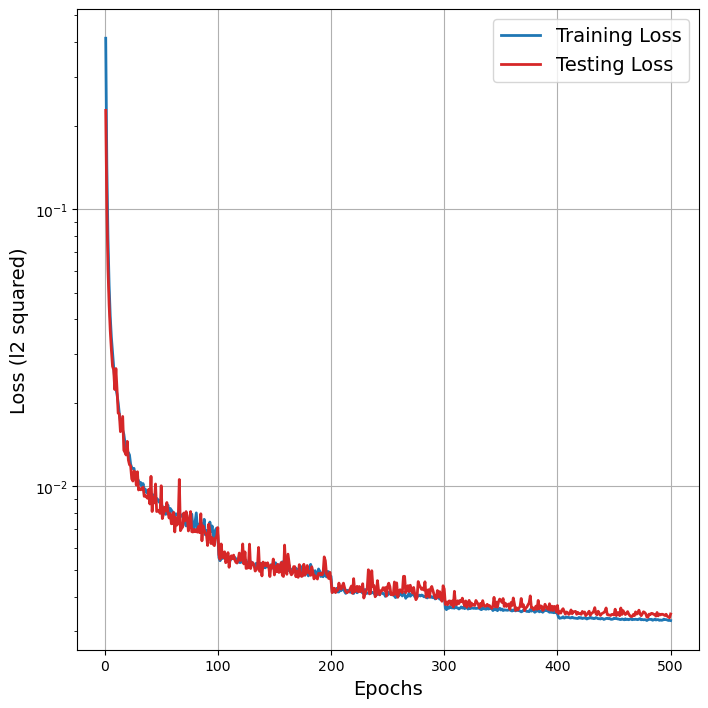

In [9]:
## Plotting the loss history

plot_loss( model.train_loss_log[:, 0], \
           model.test_loss_log[:, 0], \
           fs = 14, lw = 2, \
           savefile = results_dir+'loss_his.png', \
           figsize = [7,7])

## Test and plot the output of network

In [10]:
# load the model
model = torch.load(model_save_file, weights_only=False)

In [11]:
Y_test = test_data['Y_train'].detach().numpy()
Y_test_pred = model.predict(test_data['X_train']).detach().cpu().numpy()
print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))
a = Y_test.reshape(Y_test.shape[0], -1)
b = Y_test_pred.reshape(Y_test_pred.shape[0], -1)
print('a shape: {}, b shape: {}'.format(a.shape, b.shape))
error = np.linalg.norm(a - b, axis = 1)/np.linalg.norm(a, axis = 1)
print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (1000, 51, 51, 1), test_pred shape: (1000, 51, 51, 1)
a shape: (1000, 2601), b shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 6.913e-02, Std Loss (rel l2): 2.183e-02


In [12]:
def apply_grid_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids[:, 0], bc_node_ids[:,1]] = bc_value
    return u

i_plot =   993, error (rel l2): 4.035e-03
i_plot =   859, error (rel l2): 6.803e-03
i_plot =   298, error (rel l2): 4.268e-03
i_plot =   553, error (rel l2): 6.493e-03


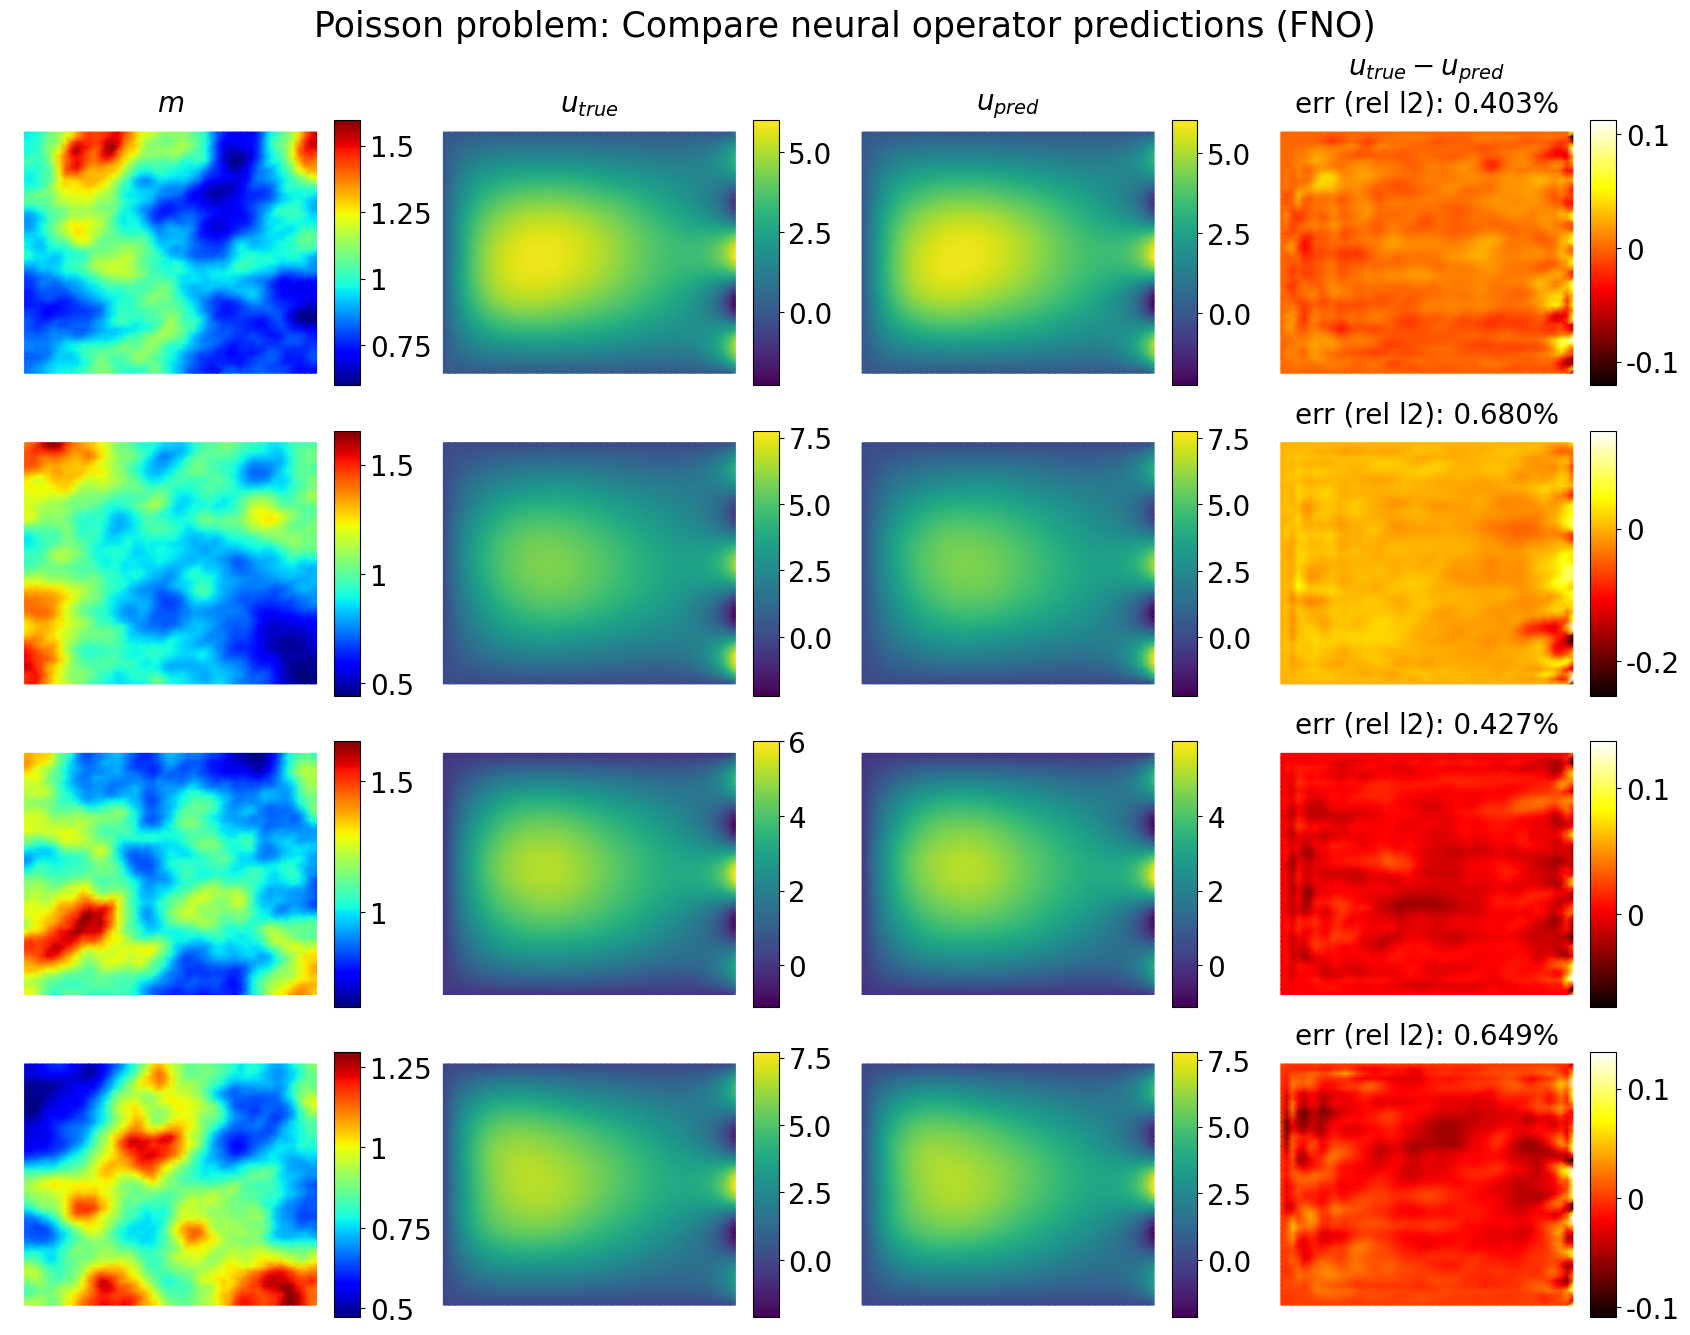

In [13]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(17, 13))

decode = True
apply_dirichlet_bc_flag = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

grid_x, grid_y = data.grid_x_test[0], data.grid_y_test[0]

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)[:, :, 0]
        i_truth = data.decoder_Y(i_truth)[:, :, 0]
        i_m_test = data.decoder_X(i_m_test)[:, :, 0]
    else:
        i_pred = i_pred[:, :, 0]
        i_truth = i_truth[:, :, 0]
        i_m_test = i_m_test[:, :, 0]
    if apply_dirichlet_bc_flag:
        i_pred = apply_grid_dirichlet_bc(i_pred, 0.0, data.u_grid_dirichlet_boundary_nodes)
        i_truth = apply_grid_dirichlet_bc(i_truth, 0.0, data.u_grid_dirichlet_boundary_nodes)
        # # verify for i_truth
        # a = i_truth[i, data.u_grid_dirichlet_boundary_nodes[:,0], data.u_grid_dirichlet_boundary_nodes[:,1]]
        # if np.abs(a).max() > 1.0e-9:
        #     print('Warning: Dirichlet BC not applied to i_truth. Err : {}'.format(a.max()))
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff.flatten()) / np.linalg.norm(i_truth.flatten())
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        
        cbar = field_plot_grid(axs[i,j], uvec[j], grid_x, grid_y, cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Poisson problem: Compare neural operator predictions ({})'.format(model.name), fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()

## Uncertainty Quantification Sampling

## HMC

In [14]:
hmc_num_samples = 500       # Number of posterior samples to collect
hmc_burn_in = 100           # Burn-in iterations
hmc_leapfrog_steps = 10     # Number of leapfrog steps per iteration
hmc_initial_step_size = 1e-7  # Initial leapfrog step size
hmc_target_accept = 0.75    # Target acceptance rate (0.75-0.80 is optimal for HMC)
hmc_prior_std = 1.0         # Prior std on weights
hmc_noise_std = 0.05        # Observation noise std
hmc_batch_size = None       # Use full batch for HMC (mini-batch can hurt acceptance)

model = torch.load(model_save_file, weights_only=False)
model.to(device)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Prepare training data for log probability
X_train_tensor = train_data["X_train"].clone().detach().to(device)
Y_train_tensor = train_data["Y_train"].clone().detach().to(device)

# Create log probability function (use smaller batch_size if CUDA OOM)
hmc_log_prob_fn = uq.make_log_prob_fn(
    model, X_train_tensor, Y_train_tensor,
    prior_std=hmc_prior_std,
    noise_std=hmc_noise_std,
    batch_size=hmc_batch_size
)
hmc_flat0 = uq.pack_params(model).to(device)

# Run Adaptive HMC
print("Running HMC sampling...")
hmc_samples, hmc_accept_rate, hmc_final_step_size, hmc_step_size_history = uq.hmc_adaptive(
    hmc_log_prob_fn,
    hmc_flat0.requires_grad_(True),
    target_accept=hmc_target_accept,
    initial_step_size=hmc_initial_step_size,
    leapfrog_steps=hmc_leapfrog_steps,
    num_samples=hmc_num_samples,
    burn_in=hmc_burn_in
)
print(f"HMC completed.")
print(f"  Final acceptance rate: {hmc_accept_rate:.3f}")
print(f"  Final step size: {hmc_final_step_size:.2e}")
print(f"  Number of samples collected: {len(hmc_samples)}")

torch.save(hmc_samples, model_save_path + 'hmc_samples.pt')

Running HMC sampling...
Starting adaptive HMC with target acceptance rate: 75.00%
Adaptation will run for 80 iterations
Iter   50/600: accept rate = 0.000, step_size = 1.00e-08, phase = adapting

>>> Adaptation complete! Final step size: 1.00e-08
>>> Acceptance rate during adaptation: 0.000

Iter  100/600: accept rate = 0.000, step_size = 1.00e-08, phase = burn-in
Iter  150/600: accept rate = 0.000, step_size = 1.00e-08, phase = sampling
Iter  200/600: accept rate = 0.000, step_size = 1.00e-08, phase = sampling
Iter  250/600: accept rate = 0.000, step_size = 1.00e-08, phase = sampling
Iter  300/600: accept rate = 0.000, step_size = 1.00e-08, phase = sampling
Iter  350/600: accept rate = 0.000, step_size = 1.00e-08, phase = sampling
Iter  400/600: accept rate = 0.000, step_size = 1.00e-08, phase = sampling
Iter  450/600: accept rate = 0.000, step_size = 1.00e-08, phase = sampling
Iter  500/600: accept rate = 0.000, step_size = 1.00e-08, phase = sampling
Iter  550/600: accept rate = 0.00

## SGLD Uncertainty Quantification

In [15]:
# SGLD Sampling Parameters (better suited for mini-batch than HMC)
num_samples = 500      # Number of posterior samples to collect
burn_in = 100          # Burn-in iterations
step_size = 1e-5       # Initial step size for SGLD
step_decay = 0.9995    # Step size decay per iteration
min_step_size = 1e-7   # Minimum step size
prior_std = 1.0        # Prior std on weights
noise_std = 0.05       # Observation noise std
sgld_batch_size = 100  # Mini-batch size for memory efficiency

model = torch.load(model_save_file, weights_only=False)
model.to(device)
# Run SGLD Sampling (works better with mini-batching than HMC)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Prepare training data for log probability
X_train_tensor = train_data["X_train"].clone().to(device)
Y_train_tensor = train_data["Y_train"].clone().to(device)

# Create log probability function with mini-batch for memory efficiency
log_prob_fn = uq.make_log_prob_fn(
    model, X_train_tensor, Y_train_tensor,
    prior_std=prior_std,
    noise_std=noise_std,
    batch_size=sgld_batch_size,
    reduce_output_mean=True
)
flat0 = uq.pack_params(model).detach().requires_grad_(True)

# Run SGLD (Stochastic Gradient Langevin Dynamics)
# Note: SGLD is specifically designed for mini-batch settings and doesn't suffer
# from the acceptance rate issues that HMC has with stochastic gradients
print("Running SGLD sampling...")
sgld_samples, final_step_size = uq.sgld(
    log_prob_fn,
    flat0,
    step_size=step_size,
    num_samples=num_samples,
    burn_in=burn_in,
    step_decay=step_decay,
    min_step_size=min_step_size
)
sgld_samples = torch.stack(sgld_samples)
print(f"SGLD completed. Final step size: {final_step_size:.2e}")
print(f"Number of samples collected: {len(sgld_samples)}")

torch.save(sgld_samples, model_save_path + 'sgld_samples.pt')

Running SGLD sampling...
Starting SGLD sampling...
  Burn-in: 100, Samples: 500
  Initial step size: 1.00e-05
Iter  100/600: step_size = 9.51e-06, phase = burn-in
Iter  200/600: step_size = 9.05e-06, phase = sampling
Iter  300/600: step_size = 8.61e-06, phase = sampling
Iter  400/600: step_size = 8.19e-06, phase = sampling
Iter  500/600: step_size = 7.79e-06, phase = sampling
Iter  600/600: step_size = 7.41e-06, phase = sampling
SGLD completed. Collected 500 samples.
SGLD completed. Final step size: 7.41e-06
Number of samples collected: 500


## MC Dropout 


In [16]:
# It suffices to sample when evaluating.

## Laplace Approximation

In [17]:
prior_precision = 1.0
prior_std = 1.0   
noise_std = 0.05        
epoch_la = 100      

# Compute Diagonal Hessian for Laplace Approximation
print("Computing diagonal Hessian...")

model = torch.load(model_save_file, weights_only=False)
model.to(device)

# Use a subset of training data for Hessian computation (for efficiency)
X_train_tensor = train_data["X_train"].clone().to(device)
Y_train_tensor = train_data["Y_train"].clone().to(device)
n_hessian = min(100, num_train)
X_hessian = X_train_tensor[:n_hessian]
Y_hessian = Y_train_tensor[:n_hessian]

# Compute diagonal Hessian (note: function signature includes noise_std, prior_std, device)
diag_hessian = uq.compute_diagonal_hessian(
    model, X_hessian, Y_hessian,
    noise_std=noise_std,
    prior_std=prior_std,
    device=device,
    batch_size=20,
    sample_points_per_batch=50
)

# Compute posterior precision and variance (diagonal approximation)
# posterior_precision = prior_precision + data_precision * Hessian
# Note: The prior term is already included in compute_diagonal_hessian
posterior_precision = diag_hessian  # Already includes prior term
posterior_variance = 1.0 / (posterior_precision + 1e-10)

print(f"Number of parameters: {len(diag_hessian)}")
print(f"Mean posterior variance: {posterior_variance.mean().item():.7e}")
print(f"Max posterior variance: {posterior_variance.max().item():.7e}")
# Sample from Laplace Posterior and Make Predictions
print("Sampling from Laplace posterior...")

# Get MAP parameters (this is the flattened real-valued parameter vector)
map_params = uq.pack_params(model).to(device)
# Sample from Gaussian posterior
posterior_std = torch.sqrt(posterior_variance)
la_samples=[]
for i in range(epoch_la):
    noise = torch.randn_like(map_params) * posterior_std
    sampled_params = map_params + noise
    la_samples.append(sampled_params)
la_samples = torch.stack(la_samples) 
torch.save(la_samples, model_save_path + 'la_samples.pt')


Computing diagonal Hessian...
  Processed 100/100 samples
Number of parameters: 308561
Mean posterior variance: 8.9722127e-02
Max posterior variance: 1.0000000e+00
Sampling from Laplace posterior...


## Evaluation metrics

In [18]:
results_id = []
results_shifting = []
std_id = []
std_shifting = []
# load the samples if needed.
# hmc_samples = torch.load(model_save_path + 'hmc_samples.pt').to(device)
# sgld_samples = torch.load(model_save_path + 'sgld_samples.pt').to(device)
# la_samples = torch.load(model_save_path + 'la_samples.pt').to(device)

In [ ]:
torch.tensor(data_shifting_data[0]["Y_train"])

In [19]:
std_hmc = []
results_hmc = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'hmc', hmc_samples=hmc_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'hmc', hmc_samples=hmc_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_hmc.append(std_i)
        results_hmc.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_hmc))
results_shifting.append(np.stack(results_hmc))

TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [ ]:
std_sgld = []
results_sgld = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'sgld', sgld_samples=sgld_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'sgld', sgld_samples=sgld_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_sgld.append(std_i)
        results_sgld.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_sgld))
results_shifting.append(np.stack(results_sgld))

In [ ]:
std_mcd = []
results_mcd = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    uq.inject_dropout(model)
    torch.nn.Module.train(model)
    for module in model.modules():
        if isinstance(module, (torch.nn.Dropout, torch.nn.Dropout2d)):
            torch.nn.Module.train(module)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'mcd')
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'mcd')
        std_mcd.append(std_i)
        results_mcd.append(result_i)
    print(f" Complete {i+1} epoch")
std_shifting.append(np.stack(std_mcd))
results_shifting.append(np.stack(results_mcd))


In [ ]:
std_la = []
results_la = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'la', la_samples=la_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'la', la_samples=la_samples.clone()) # pyright: ignore[reportAttributeAccessIssue]
        std_la.append(std_i)
        results_la.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_la))
results_shifting.append(np.stack(results_la))

In [ ]:
# Save UQ results
results_id = np.array(results_id) # method*metric
results_shifting = np.array(results_shifting) # method*datatype*metric
std_id = np.array(std_id) # method*sample
std_shifting = np.array(std_shifting) # method*datatype*sample
np.savez(model_save_path + 'uq_results_fno.npz', results_id=results_id, results_shifting=results_shifting, std_id=std_id, std_shifting=std_shifting)

## Assess evaluation metrics

In [ ]:
# load data if needed
results_id, results_shifting, std_id, std_shifting = np.load(model_save_path + 'uq_results_fno.npz').values()

### ID data performance

In [ ]:
uq.comparison_uq(*results_id)

### Shifting data performance

In [ ]:
method = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation']
levels = [0, 0.03, 0.06, 0.1, 0.15, 0.2]
results_id_expanded = np.repeat(results_id[:, np.newaxis, :], repeats=1, axis=1)
results = np.concatenate((results_id_expanded, results_shifting[:,1:,:]), axis=1)
uq.run_regression_shift(method, levels, results)

### Robustness check

In [ ]:
uq.comparison_uq(*results_shifting[:,0,:])

In [ ]:
method = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation']
levels = [0, 0.03, 0.06, 0.1, 0.15, 0.2]
uq.run_regression_shift(method, levels, results_shifting)

## OOD data detection

In [ ]:
uq_methods_list = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation']
datatypes = ['0.03', '0.06', '0.1', '0.15', '0.2', '-0.2']
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(24, 10), sharex=True, sharey=True)
for i, uqmethod in enumerate(uq_methods_list):     
    for j, dt in enumerate(datatypes):
        ax = axes[i, j]
        ood = np.concatenate((std_id[i], std_shifting[i][j+1]), axis = 0)
        ood = ood / np.max(ood)
        oods = np.concatenate((np.zeros(std_id[i].shape[0]), np.ones(std_shifting[i][j+1].shape[0])), axis = 0)
        auroc = roc_auc_score(oods, ood)
        fpr, tpr, _ = roc_curve(oods, ood)
        print(f"Method: {uqmethod}, Data: {dt} -> AUROC: {auroc:.4f}")
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auroc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        if i == 0:
            ax.set_title(f"Data: {dt}", fontsize=12, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{uqmethod}\nTPR", fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel("")
        if i == 2:
            ax.set_xlabel('FPR')
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# If robustness check fails, compare between new samples.
uq_methods_list = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation']
datatypes = ['0.03', '0.06', '0.1', '0.15', '0.2', '-0.2']
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(24, 10), sharex=True, sharey=True)
for i, uqmethod in enumerate(uq_methods_list):     
    for j, dt in enumerate(datatypes):
        ax = axes[i, j]
        ood = np.concatenate((std_shifting[0], std_shifting[i][j+1]), axis = 0)
        ood = ood / np.max(ood)
        oods = np.concatenate((np.zeros(std_shifting[0].shape[0]), np.ones(std_shifting[i][j+1].shape[0])), axis = 0)
        auroc = roc_auc_score(oods, ood)
        fpr, tpr, _ = roc_curve(oods, ood)
        print(f"Method: {uqmethod}, Data: {dt} -> AUROC: {auroc:.4f}")
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auroc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        if i == 0:
            ax.set_title(f"Data: {dt}", fontsize=12, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{uqmethod}\nTPR", fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel("")
        if i == 2:
            ax.set_xlabel('FPR')
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Conformal Prediction

In [ ]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
alpha = 0.1  # Target error rate (90% coverage)
n_cal = 500  # Number of samples for calibration

# Split remaining test data into calibration and final test
indices = np.arange(num_test_shift)
np.random.shuffle(indices)
cal_idx = indices[:n_cal]
test_idx = indices[n_cal:]

# Get predictions for calibration set
x_branch_cal = test_data['X_train'][cal_idx]
y_cal = test_data['Y_train'][cal_idx].reshape(test_data['Y_train'].shape[0], -1)

with torch.no_grad():
    x_b = torch.from_numpy(x_branch_cal).float().to(device)
    y_cal_pred = model.predict(x_b).cpu().numpy()
    y_cal_pred = y_cal_pred.reshape(y_cal_pred.shape[0], -1)

# Calculate non-conformity scores (Absolute Residuals)
# For vector outputs, we use point-wise absolute error
scores = np.abs(y_cal - y_cal_pred)

# Compute the (1-alpha) quantile of the scores
q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
qhat = np.quantile(scores, q_level, axis=0) # Point-wise quantile

print(f"Calibration complete using {n_cal} samples.")
print(f"Quantile (qhat) mean value: {qhat.mean():.4f}")

Calibration complete using 500 samples.
Quantile (qhat) mean value: 0.1708


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30, 5)) 
for i, datatype in enumerate(datatypes):
    
    ax = axes[i]
    # Evaluate on the remaining test set
    x_branch_final = np.concatenate((test_data['X_train'][test_idx], data_shifting_data[i+1]['X_train']), axis=0) 
    y_test_final = np.concatenate((test_data['Y_train'][test_idx], data_shifting_data[i+1]['Y_train']), axis=0) 
    y_test_final = y_test_final.reshape(y_test_final.shape[0], -1)

    with torch.no_grad():
        x_b_final = torch.from_numpy(x_branch_final).float().to(device)
        y_test_pred = model.predict(x_b_final).cpu().numpy()
        y_test_pred = y_test_pred.reshape(y_test_pred.shape[0], -1)

    # Prediction Intervals: [pred - qhat, pred + qhat]
    lower_bound = y_test_pred - qhat
    upper_bound = y_test_pred + qhat

    # Calculate empirical coverage
    cover = ((y_test_final >= lower_bound) & (y_test_final <= upper_bound)).mean(axis=1)
    coverage = cover.mean()
    cover_id = cover[:len(test_idx)]
    cover_ood = cover[len(test_idx):]
    cover_id_mean = cover_id.mean() 
    cover_ood_mean = cover_ood.mean()

    print(f"Results for alpha = {alpha} (Target Coverage: {1-alpha:.1%})")
    print(f"Empirical Test Coverage: {coverage:.1%}")
    print(f"ID Coverage: {cover_id_mean:.1%}")
    print(f"OOD Coverage: {cover_ood_mean:.1%}")
    print(f"Average Prediction Interval Width: {(upper_bound - lower_bound).mean():.4f}")


    oods = np.concatenate((np.ones(len(test_idx)), np.zeros(len(x_branch_final)-len(test_idx))), axis=0)

    auroc = roc_auc_score(oods, cover)
    fpr, tpr, _ = roc_curve(oods, cover)
    
    print(f"AUROC of {datatype} for OOD detection: {auroc}")

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auroc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')

    if i == 0:
        ax.set_ylabel('True Positive Rate')
    
    ax.set_title(f'{datatype}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 71.6%
ID Coverage: 90.3%
OOD Coverage: 65.7%
Average Prediction Interval Width: 0.3415


In [ ]:
# If robustness check fails, recalibrate using new samples.

model = torch.load(model_save_file, weights_only=False)
model.to(device)
alpha = 0.1  # Target error rate (90% coverage)
n_cal = 100  # Number of samples for calibration

# Split remaining test data into calibration and final test
indices = np.arange(num_test)
np.random.shuffle(indices)
cal_idx = indices[:n_cal]
test_idx = indices[n_cal:]

# Get predictions for calibration set
x_branch_cal = data_shifting_data[0]['X_train'][cal_idx]
y_cal = data_shifting_data[0]['Y_train'][cal_idx]
y_cal = y_cal.reshape(data_shifting_data[0]['Y_train'].shape[0], -1)

with torch.no_grad():
    x_b = torch.from_numpy(x_branch_cal).float().to(device)
    y_cal_pred = model.predict(x_b).cpu().numpy()
    y_cal_pred = y_cal_pred.reshape(y_cal_pred.shape[0], -1)

# Calculate non-conformity scores (Absolute Residuals)
# For vector outputs, we use point-wise absolute error
scores = np.abs(y_cal - y_cal_pred)

# Compute the (1-alpha) quantile of the scores
q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
qhat = np.quantile(scores, q_level, axis=0) # Point-wise quantile

print(f"Calibration complete using {n_cal} samples.")
print(f"Quantile (qhat) mean value: {qhat.mean():.4f}")

Calibration complete using 500 samples.
Quantile (qhat) mean value: 0.1699


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30, 5)) 
for i, datatype in enumerate(datatypes):
    
    ax = axes[i]
    # Evaluate on the remaining test set
    x_branch_final = np.concatenate((data_shifting_data[0]['X_train'][test_idx], data_shifting_data[i+1]['X_train']), axis=0) 
    y_test_final = np.concatenate((data_shifting_data[0]['Y_train'][test_idx], data_shifting_data[i+1]['Y_train']), axis=0) 
    y_test_final = y_test_final.reshape(y_test_final.shape[0], -1)

    with torch.no_grad():
        x_b_final = torch.from_numpy(x_branch_final).float().to(device)
        y_test_pred = model.predict(x_b_final).cpu().numpy()
        y_test_pred = y_test_pred.reshape(y_test_pred.shape[0], -1)

    # Prediction Intervals: [pred - qhat, pred + qhat]
    lower_bound = y_test_pred - qhat
    upper_bound = y_test_pred + qhat

    # Calculate empirical coverage
    cover = ((y_test_final >= lower_bound) & (y_test_final <= upper_bound)).mean(axis=1)
    coverage = cover.mean()
    cover_id = cover[:len(test_idx)]
    cover_ood = cover[len(test_idx):]
    cover_id_mean = cover_id.mean() 
    cover_ood_mean = cover_ood.mean()

    print(f"Results for alpha = {alpha} (Target Coverage: {1-alpha:.1%})")
    print(f"Empirical Test Coverage: {coverage:.1%}")
    print(f"ID Coverage: {cover_id_mean:.1%}")
    print(f"OOD Coverage: {cover_ood_mean:.1%}")
    print(f"Average Prediction Interval Width: {(upper_bound - lower_bound).mean():.4f}")


    oods = np.concatenate((np.ones(len(test_idx)), np.zeros(len(x_branch_final)-len(test_idx))), axis=0)

    auroc = roc_auc_score(oods, cover)
    fpr, tpr, _ = roc_curve(oods, cover)
    
    print(f"AUROC of {datatype} for OOD detection: {auroc}")

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auroc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')

    if i == 0:
        ax.set_ylabel('True Positive Rate')
    
    ax.set_title(f'{datatype}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()